In [1]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,classification_report
import re
from typing import Any, Iterable
from functools import lru_cache

from pymorphy3 import MorphAnalyzer #type: ignore
from stop_words import get_stop_words # type: ignore
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import mlflow
from mlflow import MlflowClient
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import boto3
import io

In [2]:
import os
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"

# Загрузка данных и разделение датасетов

In [3]:
config = {'SOURCE_BUCKET': 'bucket-mlops-project', 
'MLFLOW_URL': 'http://89.169.148.33:8000',
'MODEL_NAME': 'sentiment_analysis.model',
'EXPIRIMENT_NAME': 'sentiment_analysis2',
'MLFLOW_S3_ENDPOINT_URL': "https://storage.yandexcloud.net",
'FILE_NAME_FOR_REFFIT': "retraining_data.csv",
'FILE_NAME_FOR_TRAIN': "train_data.csv",
'FILE_NAME_FOR_HOLDOUT': "ab_test_data.csv"

}

In [16]:
def get_data(file_name):
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=config["SOURCE_BUCKET"], Key=f'data/{file_name}')
    df = pd.read_csv(io.BytesIO(obj['Body'].read()))
    return df


In [22]:
df = get_data('European_Restaurant_Reviews_full_dataset.csv')

In [24]:
train_df = df[:1000] #обучение + кросс-валидация

train_df.to_csv('../data/train_data.csv', index = False)

In [27]:
hold_out_df = df[1000:1300] #даные для оценки качества модели и ab теста

hold_out_df.to_csv('../data/ab_test_data.csv', index = False)

In [31]:
test_data = df[1300:1400] #Данные для дообучения

test_data.to_csv('../data/retraining_data.csv', index = False)

In [34]:
test_data2 = df[1400:] #Данные для тестирования

test_data2.to_csv('../data/test_data.csv', index = False)

# Анализ данных

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          1000 non-null   object
 1   Restaurant Name  1000 non-null   object
 2   Sentiment        1000 non-null   object
 3   Review Title     1000 non-null   object
 4   Review Date      1000 non-null   object
 5   Review           1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


In [40]:
train_df.isnull().sum()

Country            0
Restaurant Name    0
Sentiment          0
Review Title       0
Review Date        0
Review             0
dtype: int64

In [42]:
train_df.duplicated().sum()

44

In [44]:
train_df.drop_duplicates(inplace=True)

C:\Users\Ekaterina.Gurina\AppData\Local\Temp\ipykernel_16896\866752757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop_duplicates(inplace=True)


In [46]:
train_df['Review Year']=train_df['Review Date'].apply(lambda x:x.split()[1])
train_df['Review Year']=train_df['Review Year'].astype(int)

C:\Users\Ekaterina.Gurina\AppData\Local\Temp\ipykernel_16896\2074034298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Review Year']=train_df['Review Date'].apply(lambda x:x.split()[1])
C:\Users\Ekaterina.Gurina\AppData\Local\Temp\ipykernel_16896\2074034298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Review Year']=train_df['Review Year'].astype(int)


In [48]:
train_df['Review Month']=train_df['Review Date'].apply(lambda x:x.split()[0])
train_df['Label']=train_df['Sentiment'].map({'Positive':1,'Negative':0})

C:\Users\Ekaterina.Gurina\AppData\Local\Temp\ipykernel_16896\957997266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Review Month']=train_df['Review Date'].apply(lambda x:x.split()[0])
C:\Users\Ekaterina.Gurina\AppData\Local\Temp\ipykernel_16896\957997266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Label']=train_df['Sentiment'].map({'Positive':1,'Negative':0})


In [50]:
train_df['Length']=train_df['Review'].apply(lambda x:len(x))

C:\Users\Ekaterina.Gurina\AppData\Local\Temp\ipykernel_16896\2886957215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Length']=train_df['Review'].apply(lambda x:len(x))


In [52]:
train_df.columns

Index(['Country', 'Restaurant Name', 'Sentiment', 'Review Title',
       'Review Date', 'Review', 'Review Year', 'Review Month', 'Label',
       'Length'],
      dtype='object')

In [54]:
countries=train_df['Country'].value_counts()

Text(0.5, 1.0, 'Distribution of countries')

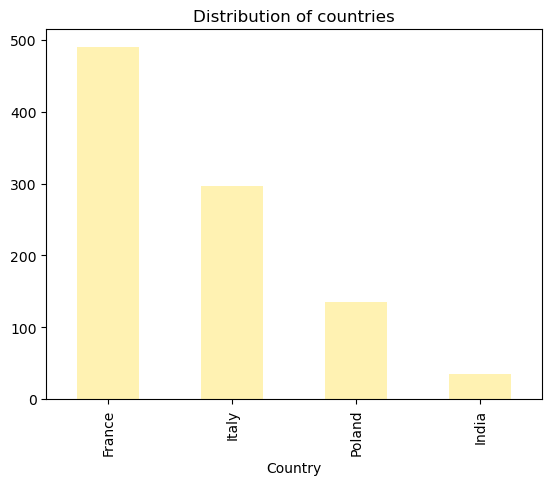

In [56]:
countries.plot(kind='bar',color='Gold',alpha=0.3)
plt.title('Distribution of countries')

In [58]:
Sentiment=train_df['Sentiment'].value_counts()

Text(0.5, 1.0, 'Distribution of Sentiment')

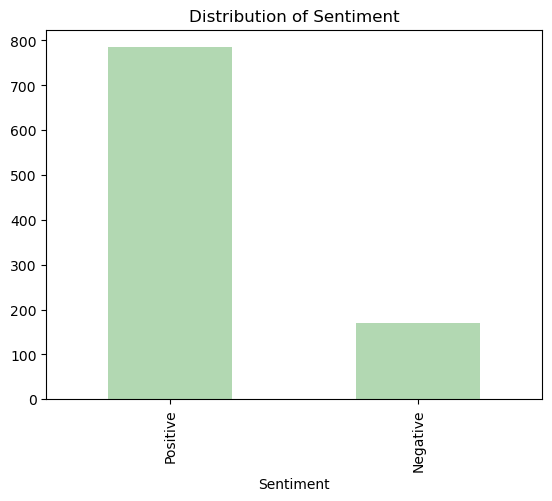

In [60]:
Sentiment.plot(kind='bar',color='Green',alpha=0.3)
plt.title('Distribution of Sentiment')

<Axes: ylabel='Percentage wise distrubution of Sentiment'>

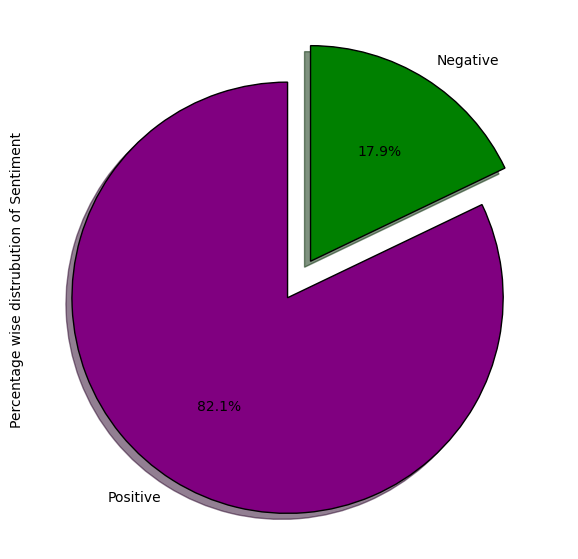

In [61]:
fig = plt.figure(figsize=(7,7))

colors = ('purple', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = train_df['Sentiment'].value_counts()/train_df.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of Sentiment')

In [64]:
ReviewYears=train_df['Review Year'].value_counts()
ReviewYears=ReviewYears.sort_values()

Text(0.5, 1.0, 'Distribution of ReviewYears')

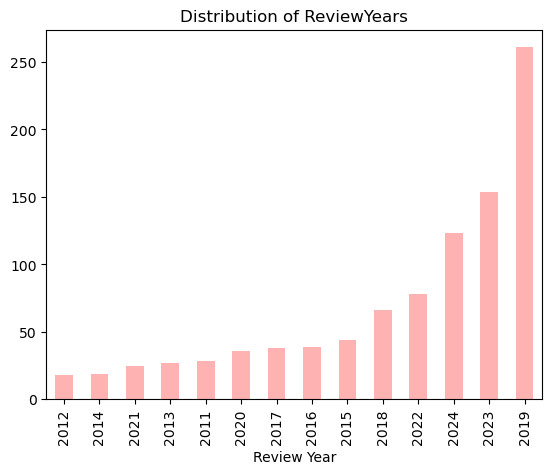

In [66]:
ReviewYears.plot(kind='bar',color='red',alpha=0.3)
plt.title('Distribution of ReviewYears')

C:\Users\Ekaterina.Gurina\AppData\Local\Temp\ipykernel_16896\2798042766.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_restaurants.values, y=top_restaurants.index, palette='plasma')


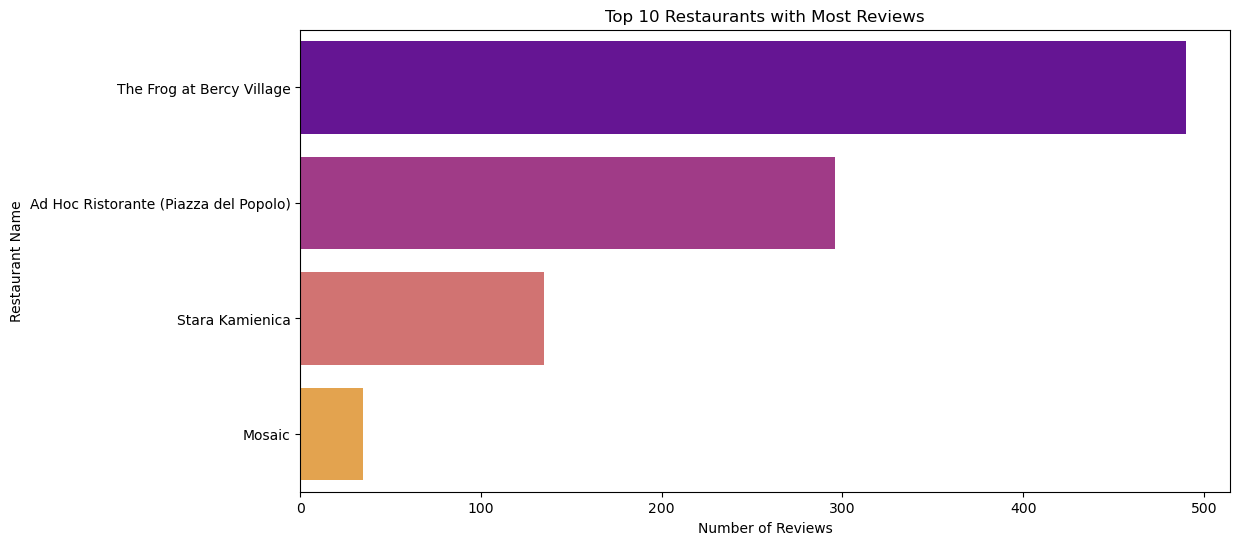

In [67]:
top_restaurants = train_df['Restaurant Name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_restaurants.values, y=top_restaurants.index, palette='plasma')
plt.title('Top 10 Restaurants with Most Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Restaurant Name')
plt.show()

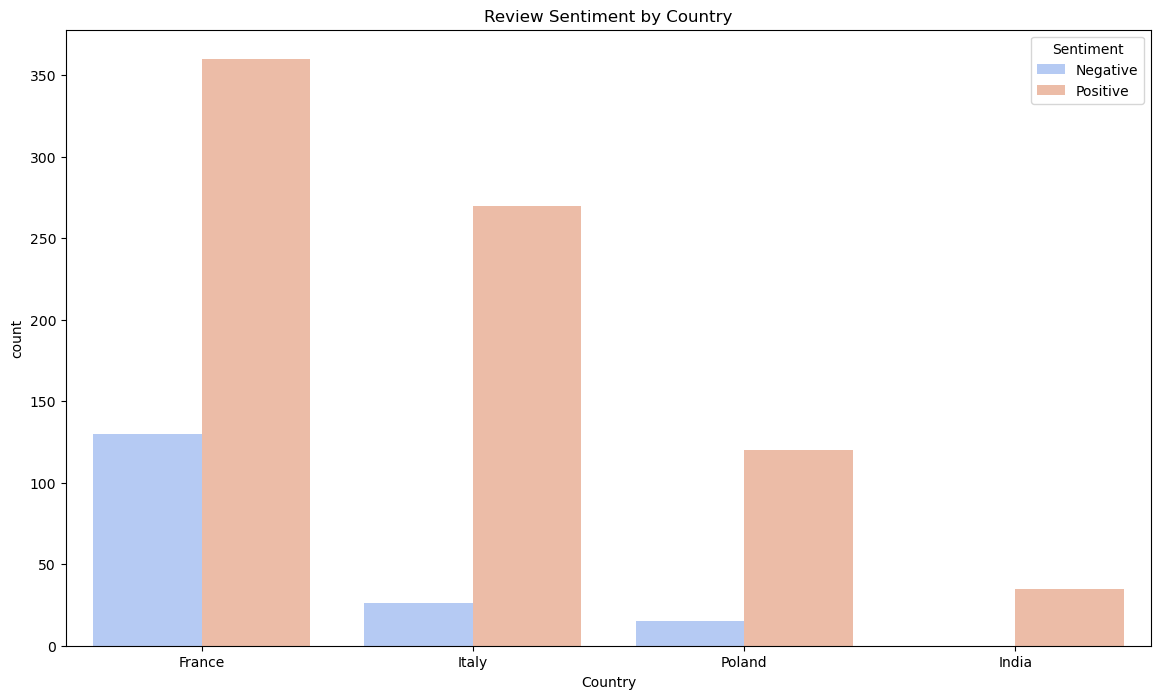

In [69]:
plt.figure(figsize=(14, 8))
sns.countplot(data=train_df, x='Country', hue='Sentiment', palette='coolwarm', order=train_df['Country'].value_counts().index)
plt.title('Review Sentiment by Country')
plt.show()

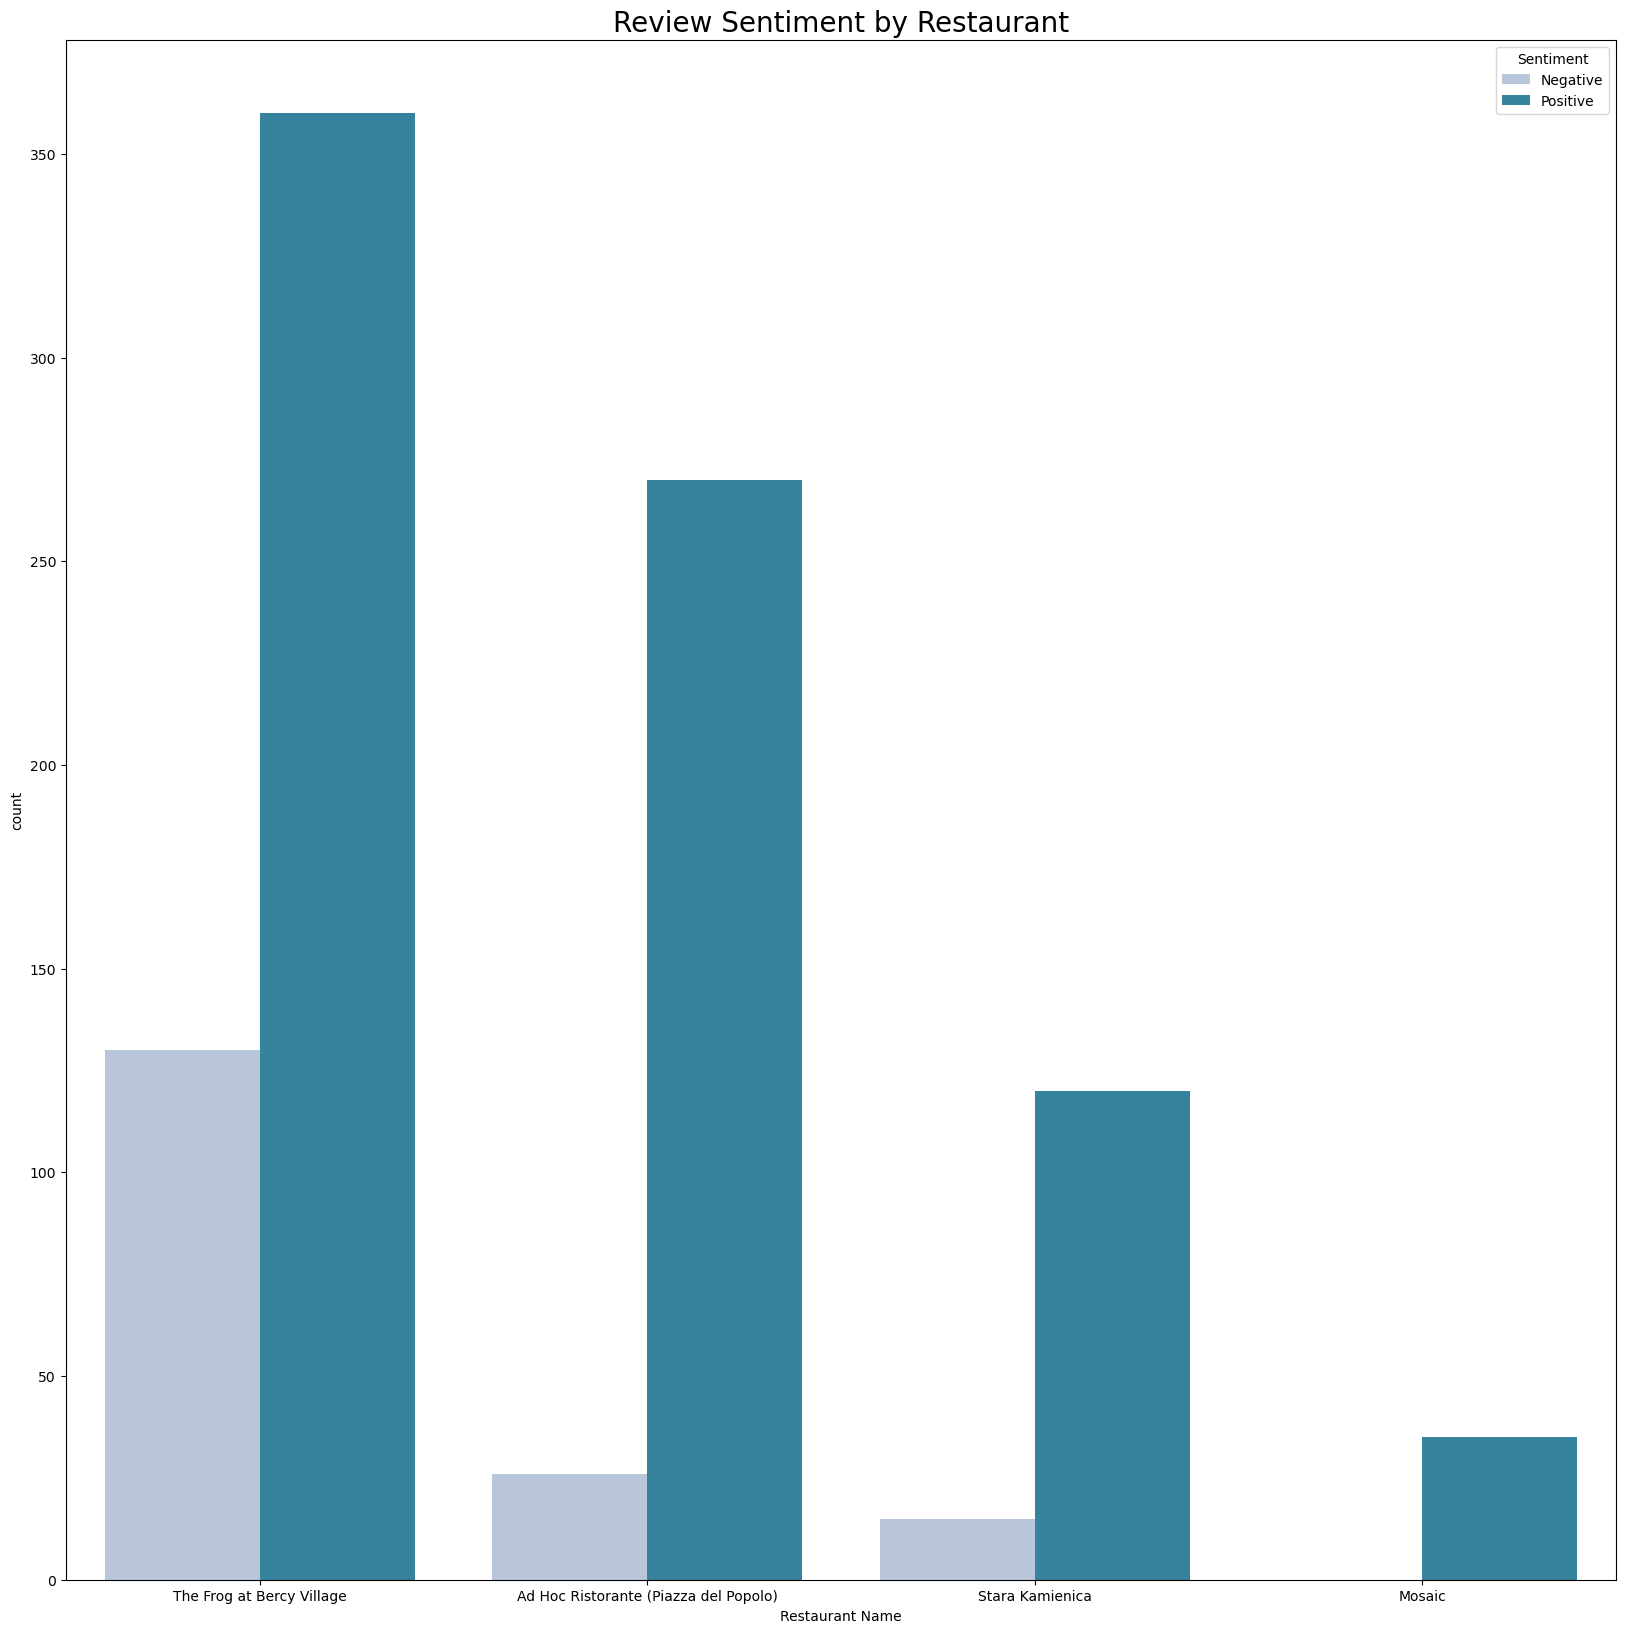

In [71]:
plt.figure(figsize=(20, 20))
sns.countplot(data=train_df, x='Restaurant Name', hue='Sentiment', palette='PuBuGn', order=train_df['Restaurant Name'].value_counts().index)
plt.title('Review Sentiment by Restaurant',fontdict={'fontsize':20})
plt.show()

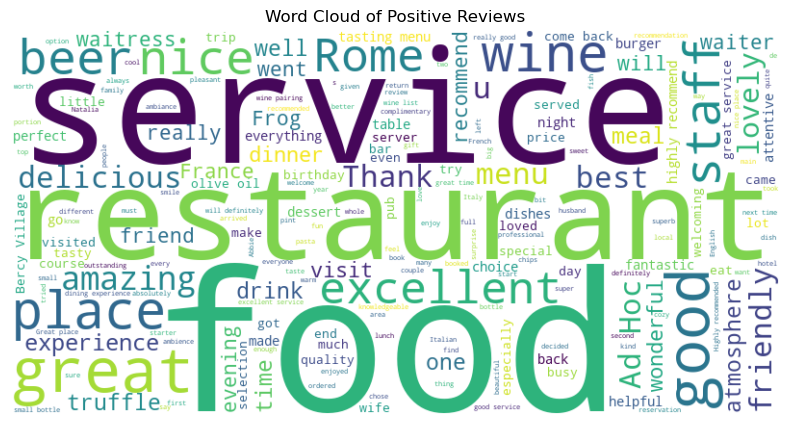

In [72]:
positive_reviews = train_df[train_df['Sentiment'] == 'Positive']['Review'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')
plt.show()


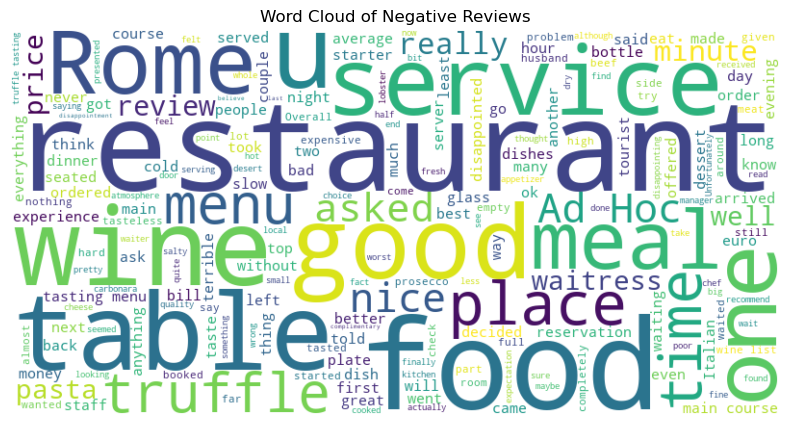

In [74]:
negative_reviews = train_df[train_df['Sentiment'] == 'Negative']['Review'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Reviews')
plt.show()

# Обучение модели

In [79]:

morph_analyzer = MorphAnalyzer()
stop_words_ru = set(get_stop_words("en"))
word_regex = re.compile(r'\w+')


@lru_cache
def get_normal_form(word: str) -> str:
  return morph_analyzer.parse(word)[0].normal_form

def lemmatize(line):
  return ' '.join(
    filter (
      lambda word: word not in stop_words_ru,
      map(
        lambda x: get_normal_form(str(x)),
        word_regex.findall(line)
      )
    )
  )

In [81]:
train_df.columns

Index(['Country', 'Restaurant Name', 'Sentiment', 'Review Title',
       'Review Date', 'Review', 'Review Year', 'Review Month', 'Label',
       'Length'],
      dtype='object')

In [83]:
train_df['text'] = train_df['Review'].apply(lemmatize) 

C:\Users\Ekaterina.Gurina\AppData\Local\Temp\ipykernel_16896\3151487671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['Review'].apply(lemmatize)


In [84]:
train_df[['Review','text', 'Label']]

,Review,text,Label
0,The manager became agressive when I said the c...,manager became agressive said carbonara good r...,0
1,"I ordered a beef fillet ask to be done medium,...",ordered beef fillet ask done medium got well d...,0
2,"This is an attractive venue with welcoming, al...",attractive venue welcoming albeit somewhat slo...,0
3,Sadly I used the high TripAdvisor rating too ...,sadly used high tripadvisor rating literally f...,0
4,From the start this meal was bad- especially g...,start meal bad especially given price visited ...,0
...,...,...,...
995,The breakfast was delicious.\nI like the omele...,breakfast delicious like omelette juice agreat...,1
996,The stay at hotels was 100% worth the hospital...,stay hotels 100 worth hospitality provide lunc...,1
997,Service. 5 star. Food great. We have had a ...,service 5 star food great pleasant time crowne...,1
998,Decent breakfast options and great service and...,decent breakfast options great service options...,1


In [87]:
hold_out_df['text'] = hold_out_df['Review'].apply(lemmatize) 
hold_out_df['Label']=hold_out_df['Sentiment'].map({'Positive':1,'Negative':0})

C:\Users\Ekaterina.Gurina\AppData\Local\Temp\ipykernel_16896\455193056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold_out_df['text'] = hold_out_df['Review'].apply(lemmatize)
C:\Users\Ekaterina.Gurina\AppData\Local\Temp\ipykernel_16896\455193056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold_out_df['Label']=hold_out_df['Sentiment'].map({'Positive':1,'Negative':0})


In [99]:
config.keys()

dict_keys(['SOURCE_BUCKET', 'MLFLOW_URL', 'MODEL_NAME', 'EXPIRIMENT_NAME', 'MLFLOW_S3_ENDPOINT_URL', 'FILE_NAME_FOR_REFFIT', 'FILE_NAME_FOR_TRAIN', 'FILE_NAME_FOR_HOLDOUT'])

In [4]:
mlflow.set_tracking_uri(config["MLFLOW_URL"])
client = MlflowClient()
experiment = client.get_experiment_by_name(config["EXPIRIMENT_NAME"])

if experiment is None:
    mlflow.set_experiment(config["EXPIRIMENT_NAME"])
    experiment = client.get_experiment_by_name(config["EXPIRIMENT_NAME"])

experiment_id = experiment.experiment_id

In [5]:
experiment_id

'677391826573756712'

In [112]:
with mlflow.start_run(run_name= 'Run time: ' + ' ' + str(datetime.now()), experiment_id=experiment_id) as run:
    pipeline = Pipeline(steps=[
      ('vectorizer', TfidfVectorizer()),
      ('model', XGBClassifier())
    ])
    scores = cross_val_score(pipeline, train_df['text'], train_df['Label'], cv = 5, scoring = 'roc_auc')
    mean_roc_auc = scores.mean()
    
    mlflow.log_metrics({'cv_roc_auc' : scores.mean()})
    mlflow.log_params(pipeline.get_params()['steps'][1][1].get_params())
    pipeline.fit(train_df['text'], train_df['Label'])
    
    mlflow.sklearn.log_model(
            sk_model=pipeline, artifact_path=config["MODEL_NAME"]
        )

    y_forecast = pipeline.predict(hold_out_df['text'])
    hold_out_metric = roc_auc_score(hold_out_df['Label'].values, y_forecast)

    mlflow.log_metrics({'hold_out_roc_auc' : hold_out_metric})

2024/08/24 16:56:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 16:56:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run time:  2024-08-24 16:55:51.738582 at: http://89.169.148.33:8000/#/experiments/677391826573756712/runs/93deefdf601743918ed8267ed4252dbe.
2024/08/24 16:56:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://89.169.148.33:8000/#/experiments/677391826573756712.


In [113]:
with mlflow.start_run(run_name= 'Run time: ' + ' ' + str(datetime.now()), experiment_id=experiment_id) as run:
    pipeline = Pipeline(steps=[
      ('vectorizer', TfidfVectorizer()),
      ('model', RandomForestClassifier())
    ])
    scores = cross_val_score(pipeline, train_df['text'], train_df['Label'], cv = 5, scoring = 'roc_auc')
    mean_roc_auc = scores.mean()
    
    mlflow.log_metrics({'cv_roc_auc' : scores.mean()})
    mlflow.log_params(pipeline.get_params()['steps'][1][1].get_params())
    pipeline.fit(train_df['text'], train_df['Label'])
    
    mlflow.sklearn.log_model(
            sk_model=pipeline, artifact_path=config["MODEL_NAME"]
        )

    y_forecast = pipeline.predict(hold_out_df['text'])
    hold_out_metric = roc_auc_score(hold_out_df['Label'].values, y_forecast)

    mlflow.log_metrics({'hold_out_roc_auc' : hold_out_metric})

2024/08/24 16:56:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 16:56:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run time:  2024-08-24 16:56:30.981103 at: http://89.169.148.33:8000/#/experiments/677391826573756712/runs/1c7d84b79b8b415fb8aa11394300e4ca.
2024/08/24 16:56:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://89.169.148.33:8000/#/experiments/677391826573756712.


In [114]:
with mlflow.start_run(run_name= 'Run time: ' + ' ' + str(datetime.now()), experiment_id=experiment_id) as run:
    pipeline = Pipeline(steps=[
      ('vectorizer', TfidfVectorizer()),
      ('model', KNeighborsClassifier())
    ])
    scores = cross_val_score(pipeline, train_df['text'], train_df['Label'], cv = 5, scoring = 'roc_auc')
    mean_roc_auc = scores.mean()
    
    mlflow.log_metrics({'cv_roc_auc' : scores.mean()})
    mlflow.log_params(pipeline.get_params()['steps'][1][1].get_params())
    pipeline.fit(train_df['text'], train_df['Label'])
    
    mlflow.sklearn.log_model(
            sk_model=pipeline, artifact_path=config["MODEL_NAME"]
        )

    y_forecast = pipeline.predict(hold_out_df['text'])
    hold_out_metric = roc_auc_score(hold_out_df['Label'].values, y_forecast)

    mlflow.log_metrics({'hold_out_roc_auc' : hold_out_metric})

2024/08/24 16:56:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 16:56:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run time:  2024-08-24 16:56:47.528921 at: http://89.169.148.33:8000/#/experiments/677391826573756712/runs/5d7c54dee7234adfb90347dd2e21b675.
2024/08/24 16:56:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://89.169.148.33:8000/#/experiments/677391826573756712.


In [117]:
runs = client.search_runs(experiment_id, "", order_by=["metrics.cv_roc_auc DESC"], max_results=1)
best_run = runs[0]

In [119]:
best_run.info.experiment_id, best_run.info.run_id

('677391826573756712', '1c7d84b79b8b415fb8aa11394300e4ca')